In [55]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 配置参数（新增device设置）
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cpu')  # 明确指定使用CPU

# 超参数配置（增加CPU优化参数）
class Config:
    # 数据参数
    n_generators = 5
    time_slots = 24
    history_days = 365
    
    # GAN参数
    noise_dim = 32
    state_dim = 5
    hidden_dim = 128
    batch_size = 32  # 减小批量大小以适应内存
    lr = 0.0002
    betas = (0.5, 0.999)
    n_epochs = 50  # 减少训练轮次（控制训练时长的关键组件）
    clip_value = 0.01
    
    
    # 物理约束参数
    min_bid = 20.0
    max_bid = 120.0
    ramp_rate = 0.2

config = Config()

数据集成板块

In [56]:
# 1. 数据模拟模块 ----------------------------------------------------------------
class MarketDataset(Dataset):
    """模拟电力市场历史数据"""
    def __init__(self):
        # 生成历史报价数据 (正态分布模拟)
        self.historical_bids = np.clip(
            np.random.normal(loc=50, scale=30, 
                           size=(config.history_days, config.n_generators, config.time_slots)),
            config.min_bid, config.max_bid
        )
        
        # 生成市场状态数据 (负荷预测 + 温度 + 风速 + 燃料价格)
        self.market_states = np.column_stack([
            np.random.normal(1000, 200, config.history_days),  # 负荷预测(MW)
            np.random.uniform(-5, 35, config.history_days),    # 温度(℃)
            np.random.uniform(0, 15, config.history_days),     # 风速(m/s)
            np.random.lognormal(3, 0.3, config.history_days),  # 天然气价格(€/MWh)
            np.random.lognormal(3, 0.3, config.history_days)   # 煤炭价格
        ])
        
        # 数据标准化
        self.state_mean = self.market_states.mean(axis=0)
        self.state_std = self.market_states.std(axis=0)
        self.market_states = (self.market_states - self.state_mean) / self.state_std
        
    def __len__(self):
        return config.history_days
    
    def __getitem__(self, idx):
        # 随机选择一个竞争对手的报价
        gen_id = np.random.randint(config.n_generators)
        bids = self.historical_bids[idx, gen_id]
        states = self.market_states[idx]
        return {
            'bids': torch.FloatTensor(bids),
            'state': torch.FloatTensor(states)
        }

模型定义板块

In [57]:
# 2. GAN模型定义 ----------------------------------------------------------------
class Generator(nn.Module):
    """生成器：输入噪声+市场状态，输出报价曲线"""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.noise_dim + config.state_dim, config.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(config.hidden_dim, config.hidden_dim * 2),
            nn.BatchNorm1d(config.hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(config.hidden_dim * 2, config.time_slots),
            nn.Tanh()  # 输出归一化到[-1,1]
        )
        
    def forward(self, noise, state):
        x = torch.cat([noise, state], dim=1)
        bids = self.net(x)
        # 缩放到实际报价范围
        return bids * (config.max_bid - config.min_bid)/2 + (config.max_bid + config.min_bid)/2

class Discriminator(nn.Module):
    """判别器：输入报价+市场状态，输出真实性概率"""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.time_slots + config.state_dim, config.hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(config.hidden_dim * 2, config.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(config.hidden_dim, 1),
            # 不适用Sigmoid，因为使用Wasserstein损失
        )
        
    def forward(self, bids, state):
        x = torch.cat([bids, state], dim=1)
        return self.net(x)


训练过程板块

In [66]:
# 3. 训练过程 ----------------------------------------------------------------
def train_gan():
    # 初始化
    dataset = MarketDataset()
    dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
    #  数据收集
    d_losses = []
    g_losses = []
    
    G = Generator().to(device)  # 使用统一设备配置
    D = Discriminator().to(device)
    
    optimizer_G = optim.Adam(G.parameters(), lr=config.lr, betas=config.betas)
    optimizer_D = optim.Adam(D.parameters(), lr=config.lr, betas=config.betas)
    
    # 训练循环
    for epoch in range(config.n_epochs):
        for i, data in enumerate(dataloader):
            # 数据移至CPU（默认已在CPU）
            real_bids = data['bids'].to(device)
            states = data['state'].to(device)
            batch_size = real_bids.size(0)
            
            # 训练判别器
            optimizer_D.zero_grad()
            
            # 真实数据损失
            d_real = D(real_bids, states)
            loss_real = -torch.mean(d_real)
            
            # 生成数据
            noise = torch.randn(batch_size, config.noise_dim).to(device)
            fake_bids = G(noise, states)
            d_fake = D(fake_bids.detach(), states)
            loss_fake = torch.mean(d_fake)
            
            # 梯度惩罚（CPU兼容实现）
            alpha = torch.rand(real_bids.size(0), 1).to(device)
            interpolates = (alpha * real_bids + (1 - alpha) * fake_bids).requires_grad_(True)
            d_interpolates = D(interpolates, states)
            gradients = torch.autograd.grad(
                outputs=d_interpolates,
                inputs=interpolates,
                grad_outputs=torch.ones_like(d_interpolates),
                create_graph=True,
                retain_graph=True,
            )[0]
            gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
            
            d_loss = loss_real + loss_fake + gradient_penalty
            d_loss.backward()
            optimizer_D.step()
            
            # 训练生成器
            if i % 5 == 0:
                optimizer_G.zero_grad()
                gen_bids = G(noise, states)
                g_loss = -torch.mean(D(gen_bids, states))
                
                # 物理约束：报价单调性
                diffs = gen_bids[:, 1:] - gen_bids[:, :-1]
                mono_penalty = torch.mean(torch.relu(-diffs)) * 0.1  # 惩罚递减报价
                
                # 爬坡率约束
                ramp_penalty = torch.mean(torch.relu(torch.abs(diffs) - config.ramp_rate)) * 0.1
                
                (g_loss + mono_penalty + ramp_penalty).backward()
                optimizer_G.step()
                
                #  数据收集
            if i == len(dataloader)-1:  #  只记录每个epoch的最后一步
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())

        # 打印训练状态
        if epoch % 100 == 0: #修改训练度
            print(f'Epoch {epoch}: D loss: {d_loss.item():.3f} | G loss: {g_loss.item():.3f}')
            
    return G, D, d_losses, g_losses

            

策略优化板块

In [67]:
# 4. 策略优化模块 ----------------------------------------------------------------
class BiddingOptimizer:
    """基于生成器模拟结果的最优报价计算"""
    
    def __init__(self, generator, dataset):
        self.G = generator
        self.dataset = dataset  # 保存数据集引用
        self.G.eval()
        
    def optimize(self, current_state, n_scenarios=50):
        """随机规划优化"""
        # 生成对手报价场景
        noise = torch.randn(n_scenarios, config.noise_dim).to(device)
        state_tensor = torch.FloatTensor(
            (current_state - self.dataset.state_mean) / self.dataset.state_std
        ).unsqueeze(0).repeat(n_scenarios, 1).to(device)
        
        with torch.no_grad():
            comp_bids = self.G(noise, state_tensor).cpu().numpy()  # [n_scenarios, 24]
        
        # 定义优化问题
        def objective(x):
            """目标函数：预期利润"""
            total_profit = 0
            for scenario in comp_bids:
                # 市场出清价格模拟（简化：按报价排序）
                all_bids = np.vstack([scenario, x.reshape(1, -1)])
                sorted_bids = np.sort(all_bids, axis=0)
                p_clear = sorted_bids[1]  # 假设市场接受第二低价
                
                # 计算利润（简化成本模型）
                cost = 30 + 0.05 * x**2  # 假设成本函数
                profit = np.sum((p_clear - cost) * x)
                total_profit += profit
            return -total_profit / n_scenarios  # 最大化利润
        
        # 约束条件
        cons = (
            {'type': 'ineq', 'fun': lambda x: config.ramp_rate - (x[1:] - x[:-1])},  # 爬坡率上升幅度限制
            {'type': 'ineq', 'fun': lambda x: (x[1:] - x[:-1]) + config.ramp_rate},  # 爬坡率下降幅度限制
            {'type': 'ineq', 'fun': lambda x: config.max_bid - x},  # 最高报价
            {'type': 'ineq', 'fun': lambda x: x - config.min_bid}   # 最低报价
        )
        
        # 求解优化
        x0 = np.full(config.time_slots, (config.min_bid + config.max_bid)/2)
        res = minimize(objective, x0, constraints=cons, method='SLSQP')
        return res.x


主程序执行板块

In [68]:
# 5. 主程序执行 ----------------------------------------------------------------
if __name__ == "__main__":
    # 训练GAN模型
    print("Training GAN model on CPU...")
    dataset = MarketDataset()
    G, D, d_losses, g_losses = train_gan()
    
    # 初始化优化器
    optimizer = BiddingOptimizer(G, dataset)
    
    # 模拟当前市场状态
    current_state = np.array([
        1200,   # 负荷预测(MW)
        25,     # 温度(℃)
        5,      # 风速(m/s)
        45,     # 天然气价格
        38      # 煤炭价格
    ])
    print("Optimizing bidding strategy")
    # 计算最优报价
    optimal_bid = optimizer.optimize(current_state)
    


Training GAN model on CPU...
Epoch 0: D loss: -3.855 | G loss: 37.986
Optimizing bidding strategy


可视化板块

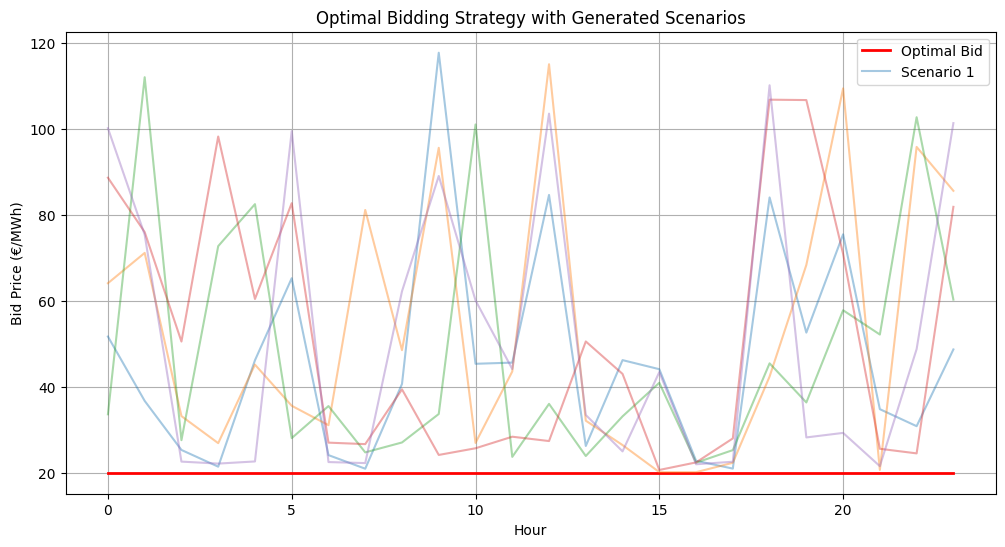

In [69]:
    # 可视化结果
    plt.figure(figsize=(12, 6))
    plt.plot(optimal_bid, label='Optimal Bid', color='red', linewidth=2)
    
    # 绘制生成样本
    noise = torch.randn(5, config.noise_dim).to(device)
    states = torch.FloatTensor(
        (current_state - dataset.state_mean) / dataset.state_std
    ).unsqueeze(0).repeat(5, 1).to(device)
    with torch.no_grad():
        sample_bids = G(noise, states).cpu().numpy()
    
    for i, bid in enumerate(sample_bids):
        plt.plot(bid, alpha=0.4, label=f'Scenario {i+1}' if i==0 else "")
    
    plt.title("Optimal Bidding Strategy with Generated Scenarios")
    plt.xlabel("Hour")
    plt.ylabel("Bid Price (€/MWh)")
    plt.legend()
    plt.grid(True)
    plt.savefig("bidding_strategy.png")
    plt.show()

In [70]:
# 在主程序调用train_gan()后添加
print(f"Total epochs recorded: {len(d_losses)}")
print("Sample Discriminator Losses:", d_losses[:5])  # 打印前5个epoch的损失
print("Sample Generator Losses:", g_losses[:5])

# 检查是否存在无效值
print("NaN in D losses:", torch.isnan(torch.tensor(d_losses)).any())
print("NaN in G losses:", torch.isnan(torch.tensor(g_losses)).any())

Total epochs recorded: 50
Sample Discriminator Losses: [-3.8547511100769043, -15.721850395202637, -27.861854553222656, -40.0673713684082, -51.8202018737793]
Sample Generator Losses: [37.98603057861328, 72.19784545898438, 114.07539367675781, 161.30616760253906, 199.80068969726562]
NaN in D losses: tensor(False)
NaN in G losses: tensor(False)


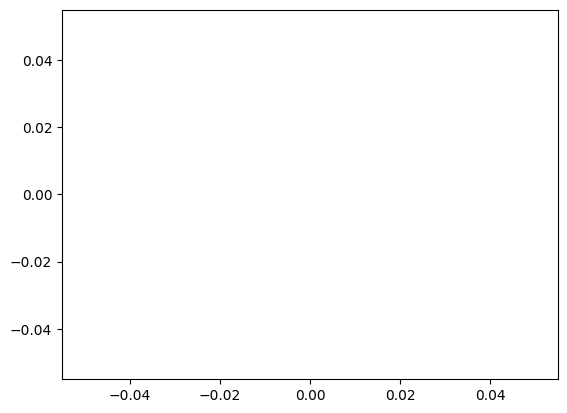

In [64]:
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.show()

NameError: name 'objective' is not defined

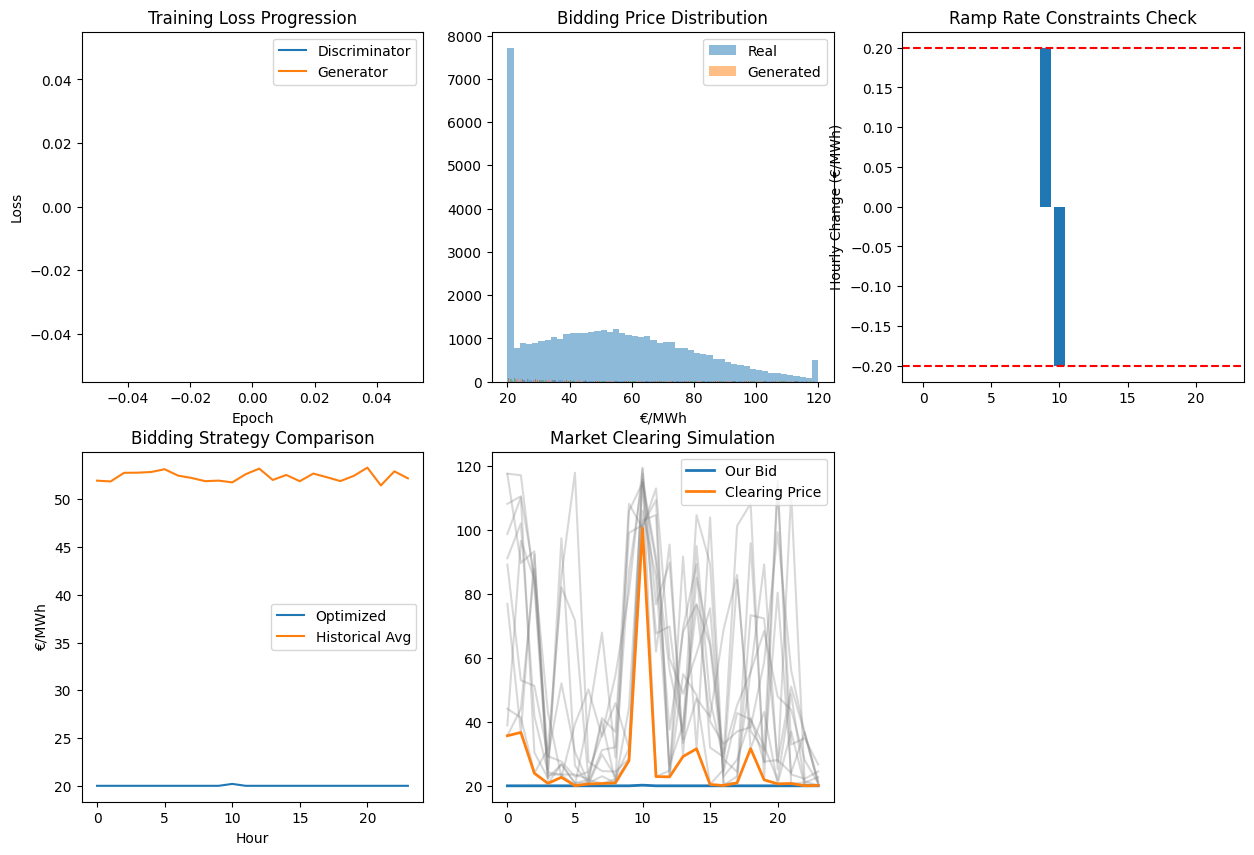

In [62]:
    # 6. 可视化分析 ----------------------------------------------------------------
    plt.figure(figsize=(15, 10))
    
    # 可视化1：训练损失曲线（需要先修改train_gan()来返回损失记录）
    # 在train_gan函数中添加损失记录（需要修改函数，此处用伪代码示意）
    d_losses = []  # 实际应从训练循环中收集
    g_losses = []  
    plt.subplot(2,3,1)
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.title("Training Loss Progression")
    plt.xlabel("Epoch"), plt.ylabel("Loss"), plt.legend()
    
    # 可视化2：真实与生成报价分布对比
    real_samples = dataset.historical_bids.reshape(-1)
    with torch.no_grad():
        with torch.no_grad():  # 禁用梯度计算
            noise = torch.randn(1000, config.noise_dim)
            states = torch.randn(1000, config.state_dim)
            fake_samples = G(noise, states).cpu().detach().numpy()  # 分离梯度
    
    plt.subplot(2,3,2)
    plt.hist(real_samples, bins=50, alpha=0.5, label='Real')
    plt.hist(fake_samples, bins=50, alpha=0.5, label='Generated')
    plt.title("Bidding Price Distribution")
    plt.xlabel("€/MWh"), plt.legend()

    # 可视化3：物理约束检查（爬坡率）
    diffs = np.diff(optimal_bid)
    plt.subplot(2,3,3)
    plt.bar(range(len(diffs)), diffs)
    plt.axhline(y=config.ramp_rate, color='r', linestyle='--')
    plt.axhline(y=-config.ramp_rate, color='r', linestyle='--')
    plt.title("Ramp Rate Constraints Check")
    plt.ylabel("Hourly Change (€/MWh)")
    
    # 可视化4：优化策略与历史平均对比
    historical_avg = dataset.historical_bids.mean(axis=(0,1))
    plt.subplot(2,3,4)
    plt.plot(optimal_bid, label='Optimized')
    plt.plot(historical_avg, label='Historical Avg')
    plt.title("Bidding Strategy Comparison")
    plt.xlabel("Hour"), plt.ylabel("€/MWh")
    plt.legend()

    # 可视化5：市场出清价格模拟
    with torch.no_grad():
        sample_bids = G(
            torch.randn(10, config.noise_dim),
            torch.FloatTensor((current_state - dataset.state_mean)/dataset.state_std).repeat(10,1)
         ).cpu().detach().numpy()  # 分离张量
    clearing_prices = np.sort(np.vstack([sample_bids, optimal_bid[None,:]]), axis=0)[1]
    
    plt.subplot(2,3,5)
    for i in range(10):
        plt.plot(sample_bids[i], alpha=0.3, c='gray')
    plt.plot(optimal_bid, lw=2, label='Our Bid')
    plt.plot(clearing_prices, lw=2, label='Clearing Price')
    plt.title("Market Clearing Simulation")
    plt.legend()

    # 可视化6：利润敏感度分析
    fuel_prices = np.linspace(30, 60, 5)
    profits = []
    for fp in fuel_prices:
        mod_state = current_state.copy()
        mod_state[3] = fp  # 修改燃料价格
        bid = optimizer.optimize(mod_state)
        profits.append(-objective(bid))  # 使用之前定义的objective函数
        
    plt.subplot(2,3,6)
    plt.plot(fuel_prices, profits, marker='o')
    plt.title("Profit vs Fuel Price")
    plt.xlabel("Gas Price (€/MWh)"), plt.ylabel("Expected Profit")

    plt.tight_layout()
    plt.show()